# Adagrad Project: CiFAR10 Image Classification
This notebook demonstrates image classification on the, 
 

*   CiFar10 dataset, imported from the `tensorflow.keras.datasets` API,
*   using Visual Geometry Group (VGG)-16 Deep Neural Network,
*   with initial weights set to pre-trained parameters on the ImageNet Dataset.

The model features a custom classifier designed to classify the 10 classes in the CiFAR10 dataset. </br> All layers are further trained to achieve maximum `val_accuracy`



 
<!--import tensorflow as tf
cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(cluster_resolver)
tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
tpu_strategy = tf.distribute.experimental.TPUStrategy(cluster_resolver)-->

## Dependencies

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, Sequential
from tensorflow.keras.optimizers import Adam
#import tensorflow_datasets as tfds
#from keras.preprocessing.image import ImageDataGenerator
#tfds.disable_progress_bar()



  ## Helper Functions

In [2]:
def get_keras_data():
  (x_train,y_train),(x_test,y_test) = keras.datasets.cifar10.load_data()
  
  #Normalise X values to between -1 to 1
  return x_train/127 - 1, y_train, x_test/127 - 1 ,y_test


def create_model():
  base_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(32,32,3))
  base_model.trainable = True

  #Make Sequential class instance to add classifier layers
  model = Sequential(base_model)
  model.add(layers.GlobalAveragePooling2D())
  model.add(layers.Dense(10,activation='softmax'))

  return model


## Display sample image

In [ ]:
#Generate training and test dataset
x_train, y_train, x_test, y_test = get_keras_data()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


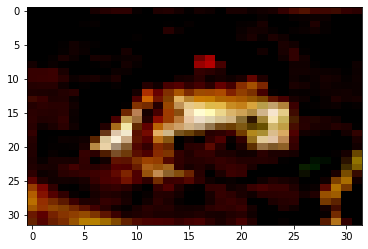

In [4]:
img = x_train[0].reshape((32,32,3))
plt.imshow(img,aspect="auto")
plt.show()

## Train the model
....base Model Visual Geometry Group (VGG16)
<!-- #callbacks = [tf.keras.callbacks.EarlyStopping(monitor='accuracy', baseline=0.98, min_delta=0.001, patience=1, mode='auto')] -->

### Distribution Strategy on GPUs
...using `tensorflow.distribute.MirroredStrategy` for faster training




In [5]:
mirrored_strategy = tf.distribute.MirroredStrategy()
with mirrored_strategy.scope():
  model = create_model()
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
58892288/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                5130      
Total params: 14,719,818
Trainable params: 14,719,818
Non-trainable params: 0
_________________________________________________________________


Listing out number of available GPUs

In [ ]:
 len(tf.config.experimental.list_physical_devices('GPU'))

### Compile Model
Optimizer: `ADAM`</br>
Loss: `sparse_categorical_crossentropy`</br>
Metric: `accuracy`</br>
Learning Rate: `0.0001`

In [10]:
model.compile(Adam(0.0001),loss="sparse_categorical_crossentropy",metrics=["accuracy"])

...training for 12 epochs!

In [11]:
history = model.fit(x_train,y_train,batch_size=64,epochs=12,validation_split=0.2) # VGG16 lr=0.0001 imagenet weights

Epoch 1/12
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tens

## Inferences

In [14]:
import time
toc = time.time()
results = model.evaluate(x_test,y_test,batch_size=64, return_dict=True)
tic = time.time()
print(results)
print('Latency: {} milli-seconds'.format((tic-toc)*1000))

157/157 [==============================] - 4s 28ms/step - accuracy: 0.8505 - loss: 0.6111
{'accuracy': 0.8504999876022339, 'loss': 0.611142098903656}
Latency: 4817.401170730591 milli-seconds


### Saving Test data
...as `.csv`

In [30]:
x_test_all = x_test.reshape(x_test.shape[0],32*32,3)
pd.DataFrame(x_test_all[:][:][0]).to_csv('x_test_channelR.csv')
pd.DataFrame(x_test_all[:][:][1]).to_csv('x_test_channelG.csv')
pd.DataFrame(x_test_all[:][:][2]).to_csv('x_test_channelB.csv')
pd.DataFrame(y_test).to_csv('y_test.csv')

...and as `.npy`

In [33]:
np.save('x-test', x_test)
np.save('y-test', y_test)

## Saving the model to disk

In [15]:
model.save('vgg16_imagenet_0001')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: vgg16_imagenet_0001/assets


### Create Zip of model to download

In [16]:
!zip -r -q VGG16 vgg16_imagenet_0001/